In [1]:
from utils import imshow, visualize_model
from train import train_model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2

cudnn.benchmark = True
plt.ion()   # interactive mode

First we construct the Datasets with the transforms and the dataloaders:

In [2]:
from torchvision.transforms.transforms import ColorJitter
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ColorJitter(0.5,0.5,0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224), # resize to 224?
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Dataset and Data_loader definition
data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Choose the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Here we see some preprocessed images from the training dataset:

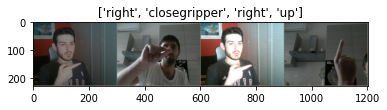

In [3]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Then we import the MobileNetv2 model and we define the Loss criterium, the optimizer and the learning rate: 

In [14]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in C:\Users\anto1/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\anto1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\anto1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We train the model and visualize some predictions on the test dataset:

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=18)

torch.save(model_ft.state_dict(), 'model_weights.pth')

Epoch 0/17
----------
train Loss: 3.2462 Acc: 0.3631
val Loss: 0.7306 Acc: 0.7761

Epoch 1/17
----------
train Loss: 1.0403 Acc: 0.6338
val Loss: 0.5287 Acc: 0.7910

Epoch 2/17
----------
train Loss: 0.6029 Acc: 0.7803
val Loss: 0.1941 Acc: 0.9701

Epoch 3/17
----------
train Loss: 0.3790 Acc: 0.8822
val Loss: 0.1134 Acc: 0.9552

Epoch 4/17
----------
train Loss: 0.2335 Acc: 0.9172
val Loss: 0.2380 Acc: 0.8955

Epoch 5/17
----------
train Loss: 0.3549 Acc: 0.8662
val Loss: 0.2177 Acc: 0.9254

Epoch 6/17
----------
train Loss: 0.2823 Acc: 0.9204
val Loss: 0.1397 Acc: 0.9701

Epoch 7/17
----------
train Loss: 0.1168 Acc: 0.9650
val Loss: 0.1076 Acc: 0.9552

Epoch 8/17
----------
train Loss: 0.1429 Acc: 0.9459
val Loss: 0.0731 Acc: 0.9701

Epoch 9/17
----------
train Loss: 0.0794 Acc: 0.9745
val Loss: 0.0556 Acc: 0.9851

Epoch 10/17
----------
train Loss: 0.1654 Acc: 0.9522
val Loss: 0.0552 Acc: 0.9851

Epoch 11/17
----------
train Loss: 0.1619 Acc: 0.9586
val Loss: 0.0827 Acc: 0.9701

Ep

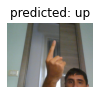

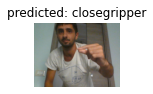

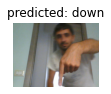

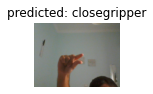

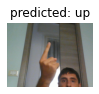

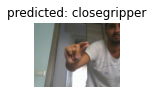

In [16]:
model_ft.load_state_dict(torch.load('model_weights.pth'))

visualize_model(model_ft, device, dataloaders, class_names)

Finally we visualize the prediction on a live video from the pc webcam:

In [29]:
from IPython.display import Image
from PIL import Image

cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


while True:
    ret, frame = cap.read()
    img = np.array(frame)
    
    # convert from openCV2 to PIL. Notice the COLOR_BGR2RGB which means that 
    # the color is converted from BGR to RGB
    color_coverted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_np=Image.fromarray(color_coverted)

    # preprocessing of the frame
    input_tensor = data_transforms['val'](image_np)
    input_batch = input_tensor.unsqueeze(0)

    # giving the frame as input to the ConvNet
    input = input_batch.to(device)
    model_ft.to(device)

    with torch.no_grad():
      output = model_ft(input)
    
    output = torch.softmax(output, 1)
    _, preds = torch.max(output, 1)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    prob = _.cpu().numpy()[0]
    label = class_names[preds]

    font = cv2.FONT_HERSHEY_SIMPLEX
    frame = cv2.putText(frame, label+ ' ' + np.format_float_positional(prob),(10,30), font, 1,(0,0,255),2,cv2.LINE_AA)
    cv2.imshow('gesture_detection',  cv2.resize(frame, (800, 600)))
    
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

tensor([0.5099], device='cuda:0')
tensor([0.7042], device='cuda:0')
tensor([0.7847], device='cuda:0')
tensor([0.7847], device='cuda:0')
tensor([0.8164], device='cuda:0')
tensor([0.6611], device='cuda:0')
tensor([0.6611], device='cuda:0')
tensor([0.5731], device='cuda:0')
tensor([0.5731], device='cuda:0')
tensor([0.6204], device='cuda:0')
tensor([0.5897], device='cuda:0')
tensor([0.5897], device='cuda:0')
tensor([0.5598], device='cuda:0')
tensor([0.5598], device='cuda:0')
tensor([0.5242], device='cuda:0')
tensor([0.5242], device='cuda:0')
tensor([0.5524], device='cuda:0')
tensor([0.6823], device='cuda:0')
tensor([0.6823], device='cuda:0')
tensor([0.5709], device='cuda:0')
tensor([0.5709], device='cuda:0')
tensor([0.6971], device='cuda:0')
tensor([0.6971], device='cuda:0')
tensor([0.8326], device='cuda:0')
tensor([0.8282], device='cuda:0')
tensor([0.8282], device='cuda:0')
tensor([0.7558], device='cuda:0')
tensor([0.7558], device='cuda:0')
tensor([0.7036], device='cuda:0')
tensor([0.7089